# `Teacher Model`

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Fri Sep 27 16:02:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
import numpy as np
import nibabel as nib
import glob
# from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Preparing Dataset

In [ ]:
# download dataset from kaggle https://www.kaggle.com/datasets/abdurrahm4n/brats-var7

!pip install kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d abdurrahm4n/brats-var7
!unzip brats-var7.zip -d brats-var7

In [15]:
!mv /content/brats-var7/SPLIT /content/

In [32]:
!rm -rf /content/brats-var7

# Data Loader

In [10]:
import os
import numpy as np

In [11]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):
            image = np.load(os.path.join(img_dir, image_name))

            images.append(image)
    images = np.array(images)

    return(images)

In [12]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y)

            batch_start += batch_size
            batch_end += batch_size

        # reseting the generator to start from the beginning
        batch_start = 0
        batch_end = batch_size

In [16]:
# testing the generator

from matplotlib import pyplot as plt
import random

train_img_dir = "/content/SPLIT/train/images"
train_mask_dir = "/content/SPLIT/train/masks"

train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

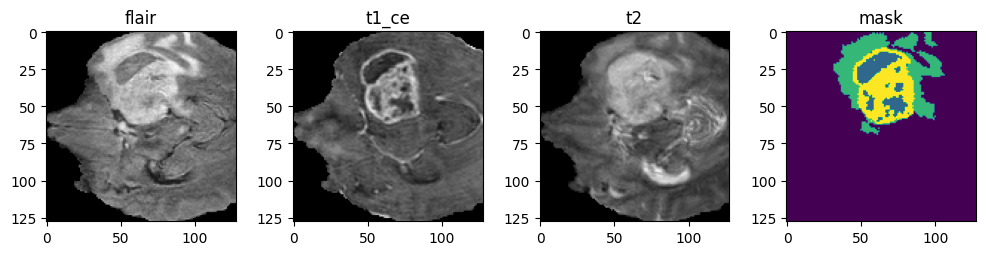

In [17]:
# verifying generator...
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(141)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('flair')
plt.subplot(142)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('t1_ce')
plt.subplot(143)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('t2')
plt.subplot(144)
plt.imshow(test_mask[:,:,n_slice])
plt.title('mask')

plt.subplots_adjust(wspace=0.3)
plt.show()

# 3D U-Net Model

In [18]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform'

In [19]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 128,  │              0 │ -                      │
│                           │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 128, 128, 128,  │          1,312 │ input_layer[0][0]      │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 128,  │              0 │ conv3d[0][0]           │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 128, 128, 128,  │          6,928 │ dropout[0][0]          │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 64, 64, 64, 16) │              0 │ conv3d_1[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 64, 32) │              0 │ conv3d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 64, 64, 64, 32) │         27,680 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 32, 32, 32, 32) │              0 │ conv3d_3[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 32, 64) │              0 │ conv3d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 32, 32, 32, 64) │        110,656 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_2           │ (None, 16, 16, 16, 64) │              0 │ conv3d_5[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_6 (Conv3D)         │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_2[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 16,     │              0 │ conv3d_6[0][0]         │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


# Train Model

In [20]:
import os
import numpy as np
import keras
from matplotlib import pyplot as plt
import glob
import random

In [21]:
train_img_dir = "/content/SPLIT/train/images"
train_mask_dir = "/content/SPLIT/train/masks"


img_list = sorted(os.listdir(train_img_dir))
msk_list = sorted(os.listdir(train_mask_dir))

num_images = len(img_list)

img_num = random.randint(0, num_images - 1)

test_img = np.load(os.path.join(train_img_dir, img_list[img_num]))
test_mask = np.load(os.path.join(train_mask_dir, msk_list[img_num]))
test_mask = np.argmax(test_mask, axis=3)

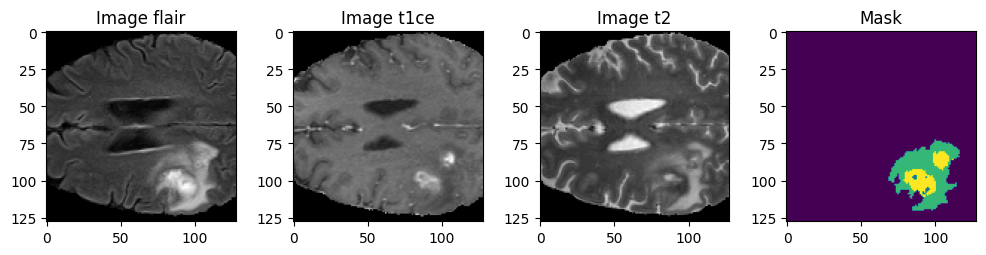

In [22]:
n_slice = random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 3))

plt.subplot(141)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(142)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(143)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(144)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')

plt.subplots_adjust(wspace=0.3)
plt.show()

In [23]:
# definin' the image generators for training and validation

train_img_dir = "/content/SPLIT/train/images"
train_mask_dir = "/content/SPLIT/train/masks"

train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_dir = "/content/SPLIT/val/images"
val_mask_dir = "/content/SPLIT/val/masks"

val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

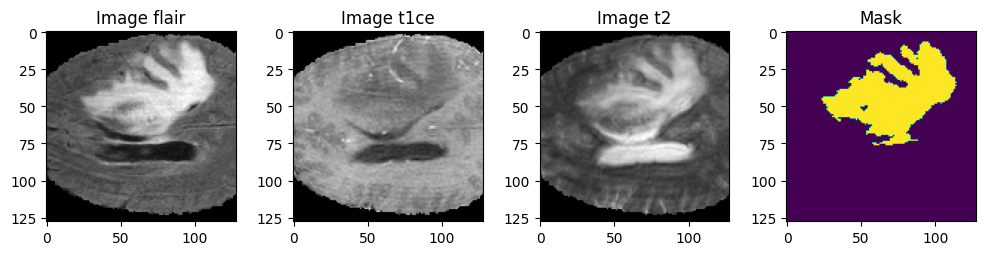

In [25]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice = random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 3))

plt.subplot(141)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(142)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(143)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(144)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')

plt.subplots_adjust(wspace=0.3)
plt.show()

In [13]:
# !pip install segmentation_models
!pip install segmentation-models-3D

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [14]:
!pip install tensorflow

In [26]:
import segmentation_models_3D as sm
from tensorflow import keras

wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.001

Segmentation Models: using `keras` framework.


In [27]:
from keras.optimizers import Adam
optim = Adam()

In [28]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [29]:
from keras.callbacks import ModelCheckpoint

In [30]:
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 128,  │              0 │ -                      │
│                           │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 128, 128, 128,  │          1,312 │ input_layer[0][0]      │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 128,  │              0 │ conv3d[0][0]           │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 128, 128, 128,  │          6,928 │ dropout[0][0]          │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 64, 64, 64, 16) │              0 │ conv3d_1[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 64, 32) │              0 │ conv3d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 64, 64, 64, 32) │         27,680 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 32, 32, 32, 32) │              0 │ conv3d_3[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 32, 64) │              0 │ conv3d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 32, 32, 32, 64) │        110,656 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_2           │ (None, 16, 16, 16, 64) │              0 │ conv3d_5[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_6 (Conv3D)         │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_2[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 16,     │              0 │ conv3d_6[0][0]         │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

None
(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


Epoch 1/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8944 - iou_score: 0.1996 - loss: 0.9542
Epoch 1: saving model to /content/models/model-01.keras

Epoch 1: val_loss improved from inf to 0.92502, saving model to /content/models/best_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.8947 - iou_score: 0.1998 - loss: 0.9541 - val_accuracy: 0.9437 - val_iou_score: 0.2475 - val_loss: 0.9250
Epoch 2/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9468 - iou_score: 0.2934 - loss: 0.9178
Epoch 2: saving model to /content/models/model-02.keras

Epoch 2: val_loss improved from 0.92502 to 0.90498, saving model to /content/models/best_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.9468 - iou_score: 0.2934 - loss: 0.9178 - val_accuracy: 0.9291 - val_iou_score: 0.3668 - val_loss: 0.9050
Epoch 3/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9477 - iou_score: 0.3658 - loss: 0.9134
Epoch 3: saving model to /content/models/model-03.ke

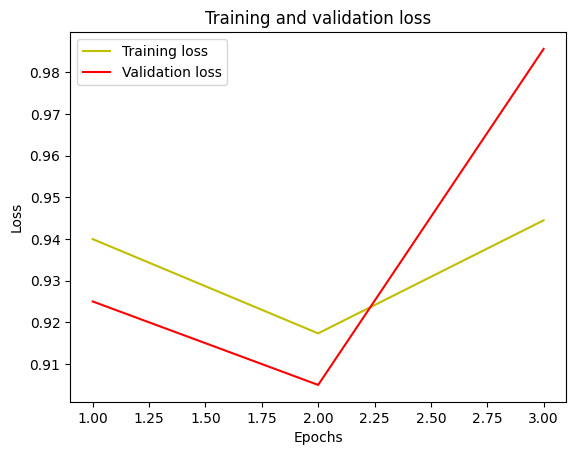

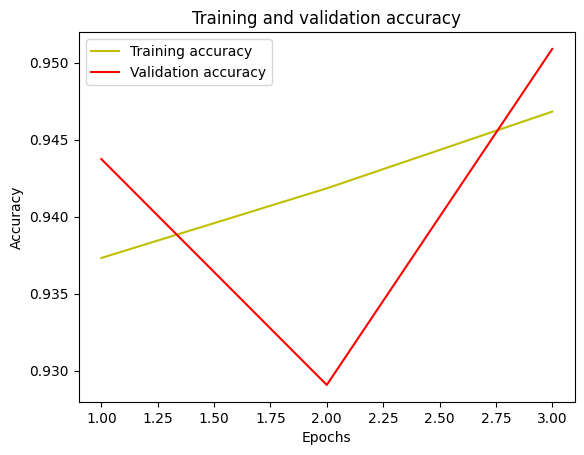

In [31]:
# ModelCheckpoint callbacks

from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

checkpoint_path_periodic = "/content/models/model-{epoch:02d}.keras"
checkpoint_path_best = "/content/models/best_model.keras"

periodic_checkpoint = ModelCheckpoint(
    checkpoint_path_periodic,
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch'
)

best_checkpoint = ModelCheckpoint(
    checkpoint_path_best,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False
)

# for 3 epochs
history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=3,
                    verbose=1,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[periodic_checkpoint, best_checkpoint])


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_validation_loss.png', dpi=400)
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure()
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_validation_accuracy.png', dpi=400)
plt.show()

# `Student Model`

In [33]:
!pip install segmentation-models-3D
from tensorflow.keras.models import load_model
from segmentation_models_3D.base.objects import SumOfLosses

custom_objects = {'SumOfLosses': SumOfLosses}

In [34]:
from segmentation_models_3D.metrics import IOUScore

def SumOfLosses_from_config(config):
    return SumOfLosses(config['config'])

def IOUScore_from_config(config):
    return IOUScore(**config)

custom_objects = {'SumOfLosses': SumOfLosses_from_config}
custom_objects['IOUScore'] = IOUScore_from_config

teacher_model = load_model('/content/models/best_model.keras', custom_objects=custom_objects)

In [35]:
def student_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    # Contraction path (fewer filters or layers compared to Teacher)
    c1 = Conv3D(8, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(s)
    c1 = Dropout(0.05)(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    # Middle (smaller depth)
    c3 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p2)
    c3 = Dropout(0.2)(c3)

    # Expansive path
    u4 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(u4)
    c4 = Dropout(0.1)(c4)

    u5 = Conv3DTranspose(8, (2, 2, 2), strides=(2, 2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv3D(8, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(u5)
    c5 = Dropout(0.05)(c5)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [36]:
import os
import numpy as np

def precompute_and_save_predictions(model, data_gen, steps_per_epoch, save_dir, batch_size, prefix):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for step in range(steps_per_epoch):
        imgs, masks = next(data_gen)

        pred = model.predict(imgs, batch_size=batch_size)
        np.save(os.path.join(save_dir, f"{prefix}_pred_batch_{step}.npy"), pred)

    print(f"Predictions saved to {save_dir}")

In [37]:
# save the precomputed teacher predictions
save_dir = "/content/teacher_preds"

precompute_and_save_predictions(teacher_model, train_img_datagen, steps_per_epoch, save_dir, batch_size, prefix='train')
precompute_and_save_predictions(teacher_model, val_img_datagen, val_steps_per_epoch, save_dir, batch_size, prefix='val')

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━

In [38]:
import os
import numpy as np

def imageLoader_with_teacher_preds_from_disk(img_dir, img_list, mask_dir, mask_list, preds_dir, batch_size, prefix):
    L = len(img_list)
    step = 0
    num_batches = len([name for name in os.listdir(preds_dir) if name.startswith(prefix)])

    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            # Load teacher's predictions, reset step if it exceeds the number of batches
            T = np.load(os.path.join(preds_dir, f"{prefix}_pred_batch_{step % num_batches}.npy"))

            yield (X, Y, T)

            batch_start += batch_size
            batch_end += batch_size
            step += 1

In [39]:
def distillation_loss(y_true, y_pred_student, teacher_preds, temperature, combined_loss):
    y_pred_teacher_soft = tf.nn.softmax(teacher_preds / temperature)
    y_pred_student_soft = tf.nn.softmax(y_pred_student / temperature)

    kl_loss = KLDivergence()(y_pred_teacher_soft, y_pred_student_soft)

    total_loss = 0.5 * kl_loss + 0.5 * combined_loss(y_true, y_pred_student)

    return total_loss

In [40]:
import segmentation_models_3D as sm

def combined_loss(y_true, y_pred):
    wt0, wt1, wt2, wt3 = 0.25, 0.25, 0.25, 0.25
    dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
    focal_loss = sm.losses.CategoricalFocalLoss()
    return dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)

In [41]:
import tensorflow as tf
import segmentation_models_3D as sm
from tensorflow.keras.losses import KLDivergence
import numpy as np

In [42]:
batch_size = 2
train_preds_dir = "/content/teacher_preds"
val_preds_dir = "/content/teacher_preds"

# use the modified generator that loads predictions from disk
train_img_datagen_with_preds = imageLoader_with_teacher_preds_from_disk(train_img_dir, train_img_list,
                                                                       train_mask_dir, train_mask_list,
                                                                       train_preds_dir, batch_size, prefix='train')

val_img_datagen_with_preds = imageLoader_with_teacher_preds_from_disk(val_img_dir, val_img_list,
                                                                     val_mask_dir, val_mask_list,
                                                                     val_preds_dir, batch_size, prefix='val')


In [44]:
model.compile(optimizer=optim,
              loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred,
                                                                  next(train_img_datagen_with_preds)[2], # Access teacher predictions from generator using next()
                                                                  temperature=5.0,
                                                                  combined_loss=combined_loss))

# trainin' the student model
history_student = model.fit(train_img_datagen_with_preds,
                                steps_per_epoch=steps_per_epoch,
                                epochs=3,
                                validation_data=val_img_datagen_with_preds,
                                validation_steps=val_steps_per_epoch)

Epoch 1/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 660s 4s/step - loss: 0.1234 - val_loss: 0.1232
Epoch 2/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 435s 3s/step - loss: 0.1234 - val_loss: 0.1232
Epoch 3/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - loss: 0.1234 - val_loss: 0.1232


In [45]:
# trained student model
model.save('/content/models/student_model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:               loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred,
                                                                  next(train_img_datagen_with_preds)[2], # Access teacher predictions from generator using next()
                                                                  temperature=5.0,
                                                                  combined_loss=combined_loss))

  return {key: serialize_keras_object(value) for key, value in obj.items()}


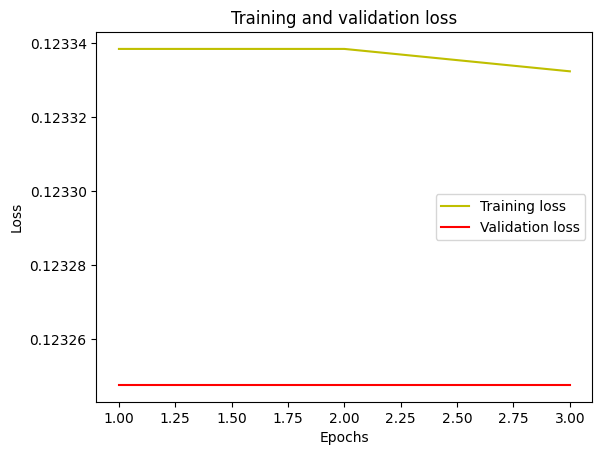

In [47]:
# Plot and save the training and validation loss
loss = history_student.history['loss']
val_loss = history_student.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_validation_loss.png', dpi=400)
plt.show()

# Trying Out Diffusion

In [72]:
# Initialize models
num_timesteps = 10
diffusion_model = DiffusionModel(num_timesteps)
student_model = student_unet_model(128, 128, 128, 3, 4)

# Compile the student model
student_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training parameters
num_epochs = 2
batch_size = 2

# Data generators
train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 128, 128, 128,  │              0 │ -                      │
│ (InputLayer)              │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_135 (Conv3D)       │ (None, 128, 128, 128,  │            656 │ input_layer_9[0][0]    │
│                           │ 8)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_81 (Dropout)      │ (None, 128, 128, 128,  │              0 │ conv3d_135[0][0]       │
│                           │ 8)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_36          │ (None, 64, 64, 64, 8)  │              0 │ dropout_81[0][0]       │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_136 (Conv3D)       │ (None, 64, 64, 64, 16) │          3,472 │ max_pooling3d_36[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_82 (Dropout)      │ (None, 64, 64, 64, 16) │              0 │ conv3d_136[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_37          │ (None, 32, 32, 32, 16) │              0 │ dropout_82[0][0]       │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_137 (Conv3D)       │ (None, 32, 32, 32, 32) │         13,856 │ max_pooling3d_37[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_83 (Dropout)      │ (None, 32, 32, 32, 32) │              0 │ conv3d_137[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_38          │ (None, 16, 16, 16, 32) │              0 │ dropout_83[0][0]       │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_138 (Conv3D)       │ (None, 16, 16, 16, 64) │         55,360 │ max_pooling3d_38[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_84 (Dropout)      │ (None, 16, 16, 16, 64) │              0 │ conv3d_138[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_39          │ (None, 8, 8, 8, 64)    │              0 │ dropout_84[0][0]       │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_139 (Conv3D)       │ (None, 8, 8, 8, 128)   │        221,312 │ max_pooling3d_39[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_85 (Dropout)      │ (None, 8, 8, 8, 128)   │              0 │ conv3d_139[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_transpose_36       │ (None, 16, 16, 16, 64) │         65,600 │ dropout_85[0][0]       │
│ (Conv3DTranspose)    

 Total params: 675,723 (2.58 MB)

 Trainable params: 675,723 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
student_model.save('/content/models/student_diffusion_model.keras')

In [78]:
import numpy as np
import tensorflow as tf

class DiffusionModel:
    def __init__(self, num_timesteps):
        self.num_timesteps = num_timesteps
        self.alpha_schedule = np.linspace(0.1, 0.9, num_timesteps)

    def forward_diffusion(self, x0):
        noise = np.random.normal(size=x0.shape)
        t = np.random.randint(0, self.num_timesteps, size=(x0.shape[0],))
        alpha_t = self.alpha_schedule[t]

        alpha_t = alpha_t[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis]
        x_t = alpha_t * x0 + (1 - alpha_t) * noise

        if x_t.shape[-1] != 4:
            if x_t.shape[-1] == 3:
                x_t = np.concatenate([x_t, np.zeros_like(x_t[..., :1])], axis=-1)
            else:
                raise ValueError(f"Unexpected channel shape in forward diffusion: {x_t.shape}")

        return x_t, noise

    def reverse_diffusion(self, x_t, model):
        for t in reversed(range(self.num_timesteps)):
            noise_pred = model.predict(x_t)

            if noise_pred.shape != x_t.shape:
                raise ValueError(f"Shape mismatch: noise_pred {noise_pred.shape}, x_t {x_t.shape}")

            # reverse diffusion step to progressively denoise
            x_t = (x_t - noise_pred) / self.alpha_schedule[t]

        return x_t

In [81]:
def student_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes=4):  # Adjust IMG_CHANNELS to 4
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))

    # Contraction path
    c1 = Conv3D(8, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
    c1 = Dropout(0.05)(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p3)
    c4 = Dropout(0.3)(c4)
    p4 = MaxPooling3D((2, 2, 2))(c4)

    # Bottleneck
    c5 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p4)
    c5 = Dropout(0.4)(c5)

    # Expansive path
    u6 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(u6)
    c6 = Dropout(0.3)(c6)

    u7 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(u7)
    c7 = Dropout(0.2)(c7)

    u8 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(u8)
    c8 = Dropout(0.1)(c8)

    u9 = Conv3DTranspose(8, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(8, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(u9)
    c9 = Dropout(0.05)(c9)

    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)  # keepin' 4 channels as the output

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

# the student model has to accept 4-channel input
student_model = student_unet_model(128, 128, 128, 4, 4)  # settin' IMG_CHANNELS to 4
student_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 128, 128, 128,  │              0 │ -                      │
│ (InputLayer)              │ 4)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_165 (Conv3D)       │ (None, 128, 128, 128,  │            872 │ input_layer_12[0][0]   │
│                           │ 8)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_108 (Dropout)     │ (None, 128, 128, 128,  │              0 │ conv3d_165[0][0]       │
│                           │ 8)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_48          │ (None, 64, 64, 64, 8)  │              0 │ dropout_108[0][0]      │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_166 (Conv3D)       │ (None, 64, 64, 64, 16) │          3,472 │ max_pooling3d_48[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_109 (Dropout)     │ (None, 64, 64, 64, 16) │              0 │ conv3d_166[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_49          │ (None, 32, 32, 32, 16) │              0 │ dropout_109[0][0]      │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_167 (Conv3D)       │ (None, 32, 32, 32, 32) │         13,856 │ max_pooling3d_49[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_110 (Dropout)     │ (None, 32, 32, 32, 32) │              0 │ conv3d_167[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_50          │ (None, 16, 16, 16, 32) │              0 │ dropout_110[0][0]      │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_168 (Conv3D)       │ (None, 16, 16, 16, 64) │         55,360 │ max_pooling3d_50[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_111 (Dropout)     │ (None, 16, 16, 16, 64) │              0 │ conv3d_168[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_51          │ (None, 8, 8, 8, 64)    │              0 │ dropout_111[0][0]      │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_169 (Conv3D)       │ (None, 8, 8, 8, 128)   │        221,312 │ max_pooling3d_51[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_112 (Dropout)     │ (None, 8, 8, 8, 128)   │              0 │ conv3d_169[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_transpose_48       │ (None, 16, 16, 16, 64) │         65,600 │ dropout_112[0][0]      │
│ (Conv3DTranspose)    

 Total params: 675,948 (2.58 MB)

 Trainable params: 675,948 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
max_batches = 3
batch_count = 0

for imgs, masks in train_img_datagen:
    print(f"Images shape: {imgs.shape}, Masks shape: {masks.shape}")

    # train
    x_t, noise = diffusion_model.forward_diffusion(imgs)

    print("Forward diffusion applied: Noisy images generated.")

    denoised_imgs = diffusion_model.reverse_diffusion(x_t, student_model)
    print(f"Denoised images shape: {denoised_imgs.shape}, Masks shape: {masks.shape}")

    batch_count += 1
    if batch_count >= max_batches:
        break

Images shape: (2, 128, 128, 128, 3), Masks shape: (2, 128, 128, 128, 4)
Forward diffusion applied: Noisy images generated.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Denoised images shape: (2, 128, 128, 128, 4), Masks shape: (2, 128, 128, 128, 4)
Images shape: (2, 128, 128, 128, 3), Masks shape: (2, 128, 128, 128, 4)
Forward diffusion applied: Noisy images generated.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━

In [83]:
import numpy as np

# the Dice Coefficient between the ground truth and predictions.
def dice_coefficient(y_true, y_pred, epsilon=1e-6):

    y_true = np.asarray(y_true).astype(np.bool_)
    y_pred = np.asarray(y_pred).astype(np.bool_)

    intersection = np.logical_and(y_true, y_pred).sum()
    dice = (2. * intersection) / (y_true.sum() + y_pred.sum() + epsilon)
    return dice

# evaluate on the denoised output
dice_score = dice_coefficient(masks, denoised_imgs)
print(f"Dice Coefficient: {dice_score:.4f}")

Dice Coefficient: 0.4000


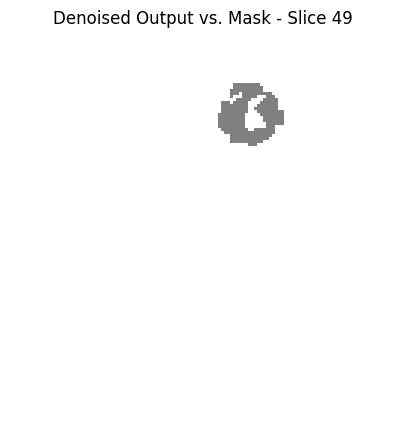

In [93]:
import matplotlib.pyplot as plt

def visualize_volume_slice(volume, mask=None, title="Volume Slice"):
    slice_idx = np.random.randint(0, volume.shape[2])
    slice_img = volume[0, :, :, slice_idx, :]

    plt.figure(figsize=(10, 5))
    plt.imshow(slice_img, cmap='gray')
    plt.title(f"{title} - Slice {slice_idx}")
    plt.axis('off')

    if mask is not None:
        slice_mask = mask[0, :, :, slice_idx, :]
        plt.imshow(slice_mask, alpha=0.5, cmap='jet')

    plt.show()

visualize_volume_slice(denoised_imgs, mask=masks, title="Denoised Output vs. Mask")